
Language Translation
======================================================

This tutorial shows, how to train a translation model from scratch using
Transformer. We will be using `Multi30k <http://www.statmt.org/wmt16/multimodal-task.html#task1>`__ 
dataset to train a German to English translation model.



Reference: [LANGUAGE TRANSLATION WITH NN.TRANSFORMER AND TORCHTEXT](https://pytorch.org/tutorials/beginner/translation_transformer.html)

## Package Installation

In [2]:
# install pytorch and huggingface transformers if you havn't done so
# !pip install torch==1.5.1
!pip install transformers==3.0.1

# if you have not installed bert_score, it is very easy
# simply uncomment the line below to install through pip
!pip install bert_score==0.3.4

In [3]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


Data Sourcing and Processing
----------------------------

`torchtext library <https://pytorch.org/text/stable/>`__ has utilities for creating datasets that can be easily
iterated through for the purposes of creating a language translation
model. In this example, we show how to use torchtext's inbuilt datasets, 
tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use
`Multi30k dataset from torchtext library <https://pytorch.org/text/stable/datasets.html#multi30k>`__
that yields a pair of source-target raw sentences. 





In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator 
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

Seq2Seq Network using Transformer
---------------------------------

Transformer is a Seq2Seq model introduced in `“Attention is all you
need” <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>`__
paper for solving machine translation tasks. 
Below, we will create a Seq2Seq network that uses Transformer. The network
consists of three parts. First part is the embedding layer. This layer converts tensor of input indices
into corresponding tensor of input embeddings. These embedding are further augmented with positional
encodings to provide position information of input tokens to the model. The second part is the 
actual `Transformer <https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>`__ model. 
Finally, the output of Transformer model is passed through linear layer
that give un-normalized probabilities for each token in the target language. 




In [5]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

During training, we need a subsequent word mask that will prevent model to look into
the future words when making predictions. We will also need masks to hide
source and target padding tokens. Below, let's define a function that will take care of both. 




In [6]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let's now define the parameters of our model and instantiate the same. Below, we also 
define our loss function which is the cross-entropy loss and the optmizer used for training.




In [7]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Collation
---------

As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
can be fed directly into our model.   




In [8]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let's define training and evaluation loop that will be called for each 
epoch.




In [9]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [10]:
# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate_sentence(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [11]:
def show_translations(model, num=10):
    
    srcs = []
    trgs = []
    pred_trgs = []

    data = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    c = 0
    for datum in data:
        if c > num:
          break
        src, trg = datum
        
        pred_trg = translate_sentence(model, src)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg.strip())
        srcs.append(src.strip())
        trgs.append(trg.strip())

        c += 1
    
    return srcs[:num], trgs[:num], pred_trgs[:num]

## Metrics
---

1) BLEU Score

In [12]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(model, max_n=4):
    
    trgs = []
    pred_trgs = []

    data = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    
    for datum in data:
        
        src, trg = datum
        
        pred_trg = translate_sentence(model, src)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg.strip().split(' '))
        trgs.append([token_transform[TGT_LANGUAGE](trg.strip())])
        
    return bleu_score(pred_trgs, trgs, max_n=max_n)

2) Bert Score

In [13]:
from bert_score import score
from transformers import logging

logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

def calculate_bert_score(model):
    
    trgs = []
    pred_trgs = []

    data = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    
    for datum in data:
        
        src, trg = datum
        
        pred_trg = translate_sentence(model, src)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg.strip())
        trgs.append([trg.strip()])

    P, R, F1 = score(pred_trgs, trgs, lang="en", verbose=False, batch_size=64)
    P, R, F1 = P.mean(), R.mean(), F1.mean()
        
    return P, R, F1

## Training Model

Now we have all the ingredients to train our model. Let's do it!




In [14]:
from timeit import default_timer as timer
import numpy as np
NUM_EPOCHS = 5

train_losses = []
val_losses = []
val_ppls = []
val_bleus = []
val_bert_Ps, val_bert_Rs, val_bert_F1s = [], [], []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_ppl = np.exp(val_loss)
    val_bleu = calculate_bleu(transformer)
    val_bert_P, val_bert_R, val_bert_F1 = calculate_bert_score(transformer)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ppls.append(val_ppl)
    val_bleus.append(val_bleu)
    val_bert_Ps.append(val_bert_P)
    val_bert_Rs.append(val_bert_R)
    val_bert_F1s.append(val_bert_F1) 

    print((f"Epoch: {epoch}:- Train loss: {train_loss:.3f} | Val PPL: {val_ppl:.3f} | Val BLEU Score: {val_bleu:.3f} | Val BERT Score: Precision - {val_bert_P:.3f}, Recall - {val_bert_R:.3f}, F1 Score - {val_bert_F1:.3f} || "f"Epoch time = {(end_time - start_time):.3f}s"))



Epoch: 1:- Train loss: 5.321 | Val PPL: 61.466 | Val BLEU Score: 0.036 | Val BERT Score: Precision - 0.844, Recall - 0.871, F1 Score - 0.857 || Epoch time = 41.566s
Epoch: 2:- Train loss: 3.768 | Val PPL: 28.040 | Val BLEU Score: 0.107 | Val BERT Score: Precision - 0.882, Recall - 0.896, F1 Score - 0.889 || Epoch time = 44.592s
Epoch: 3:- Train loss: 3.163 | Val PPL: 18.227 | Val BLEU Score: 0.166 | Val BERT Score: Precision - 0.898, Recall - 0.908, F1 Score - 0.903 || Epoch time = 43.619s
Epoch: 4:- Train loss: 2.771 | Val PPL: 13.789 | Val BLEU Score: 0.204 | Val BERT Score: Precision - 0.906, Recall - 0.917, F1 Score - 0.911 || Epoch time = 44.338s
Epoch: 5:- Train loss: 2.481 | Val PPL: 11.615 | Val BLEU Score: 0.234 | Val BERT Score: Precision - 0.913, Recall - 0.924, F1 Score - 0.918 || Epoch time = 44.738s


In [14]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Save Model

In [38]:
torch.save(transformer.state_dict(), 'gdrive/MyDrive/TSAI_END2/Session9/nlp_metric_transformer.pt')

Load Model

In [15]:
transformer.load_state_dict(torch.load('gdrive/MyDrive/TSAI_END2/Session9/nlp_metric_transformer.pt'))

<All keys matched successfully>

## Visualizations

In [20]:
import matplotlib.pyplot as plt

# visualize accuracy and loss graph
def visualize_graph(train_losses, test_losses, val_ppls, val_bleus, val_bert_Ps, val_bert_Rs, val_bert_F1s):
  fig, axs = plt.subplots(4,2,figsize=(20,20))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 0].plot(val_ppls)
  axs[1, 0].set_title("Test Perplexity")
  axs[1, 1].plot(val_bleus)
  axs[1, 1].set_title("Test Bleu Scores")
  axs[2, 0].plot(val_bert_Ps)
  axs[2, 0].set_title("Test Bert Score Precision")
  axs[2, 1].plot(val_bert_Rs)
  axs[2, 1].set_title("Test Bert Score Recall")
  axs[3, 0].plot(val_bert_F1s)
  axs[3, 0].set_title("Test Bert Score F1 Score")

def visualize_save_train_vs_test_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  #epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    x = np.linspace(1, EPOCHS+1, len(item))
    plt.plot(x, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/"+name+".png")

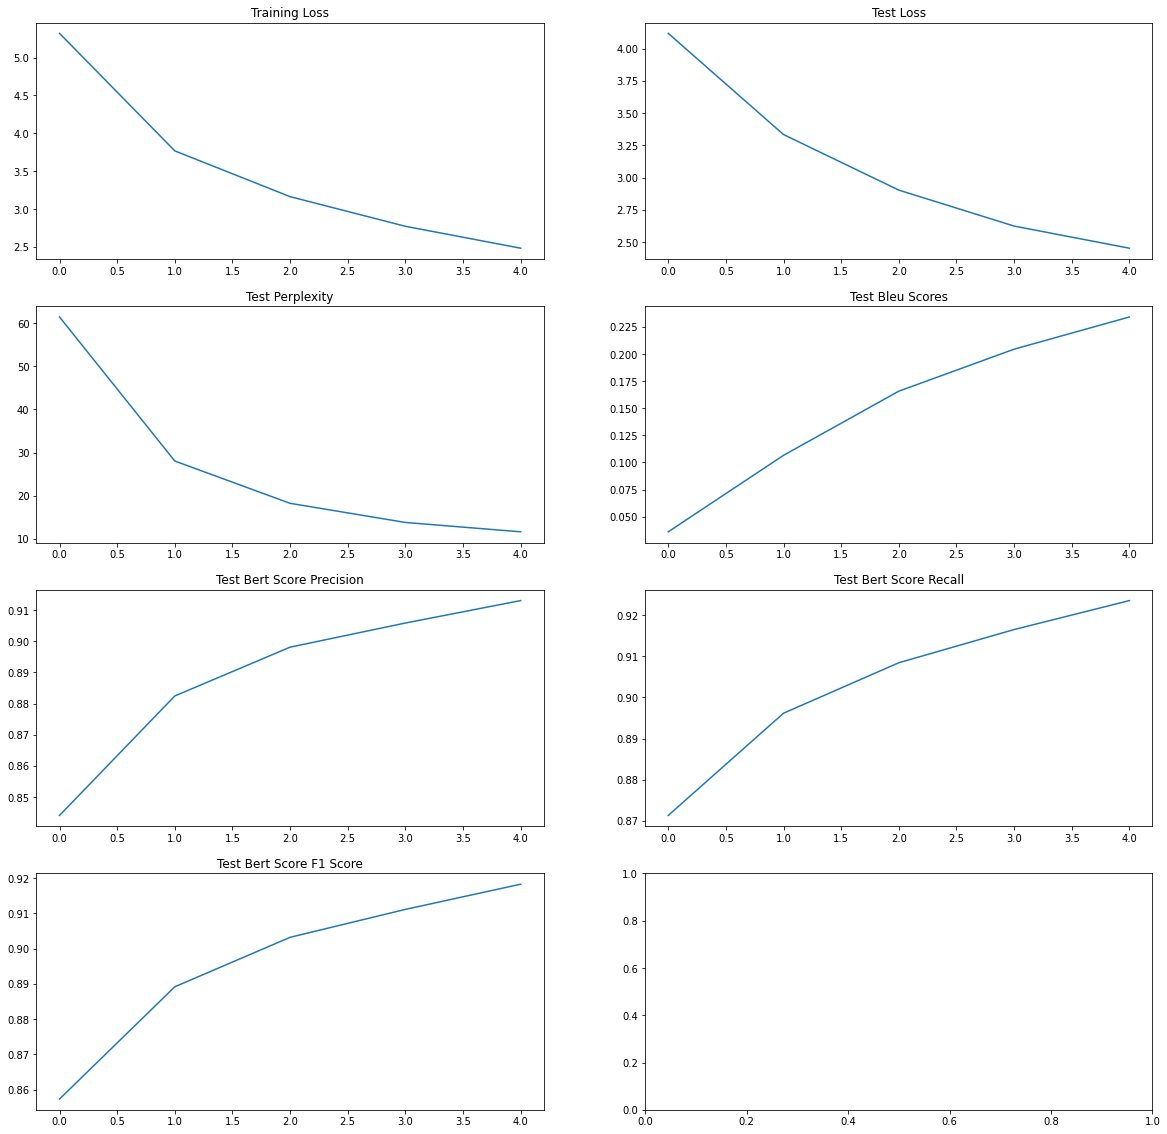

In [21]:
visualize_graph(train_losses, val_losses, val_ppls, val_bleus, val_bert_Ps, val_bert_Rs, val_bert_F1s)

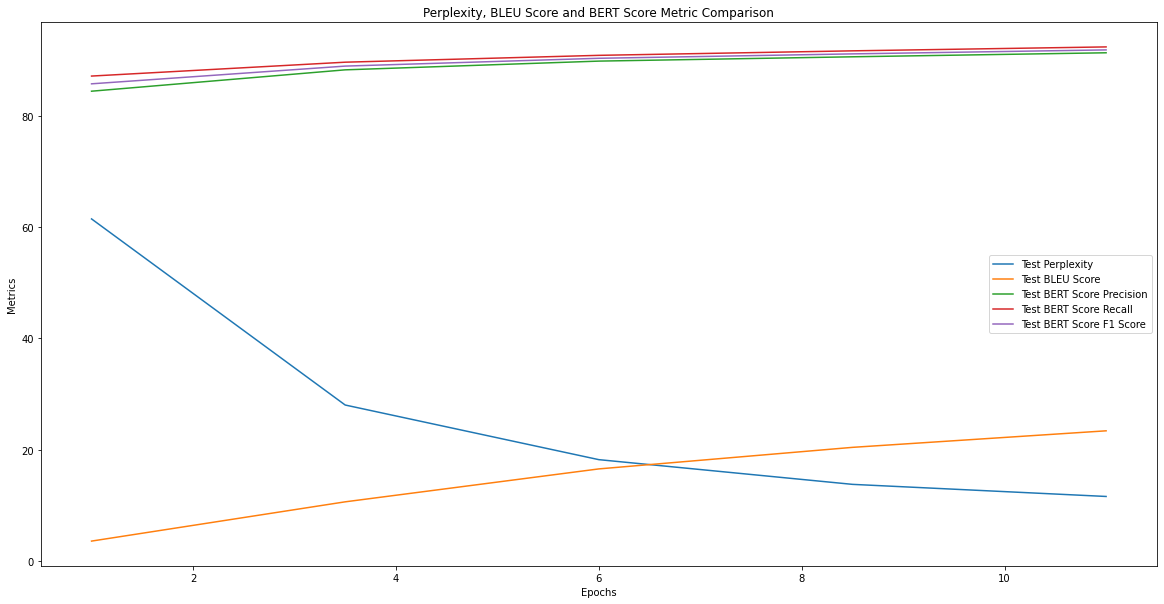

In [30]:
dict_list = {'Test Perplexity': val_ppls, 'Test BLEU Score': [v*100 for v in val_bleus], 'Test BERT Score Precision': [v.item()*100 for v in val_bert_Ps], 'Test BERT Score Recall': [v.item()*100 for v in val_bert_Rs], 'Test BERT Score F1 Score': [v.item()*100 for v in val_bert_F1s]}
title = "Perplexity, BLEU Score and BERT Score Metric Comparison"
xlabel = "Epochs"
ylabel = "Metrics"
name = "metric_comparison_graph"
EPOCHS = 10

visualize_save_train_vs_test_graph(EPOCHS, dict_list, title, xlabel, ylabel, './', name=name)

## Predictions

In [31]:
print(translate_sentence(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people standing in front of a crowd . 


In [16]:
num = 10
src,trg,pred = show_translations(transformer, num)
print('German to English Translation:')
for i in range(num):
  print(f'{i+1})  German: {src[i]}')
  print(f'    English(Target): {trg[i]}')
  print(f'    English(Predicted): {pred[i]}')

German to English Translation:
1)  German: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
    English(Target): A group of men are loading cotton onto a truck
    English(Predicted): A group of men are working on a truck that is being arts .
2)  German: Ein Mann schläft in einem grünen Raum auf einem Sofa.
    English(Target): A man sleeping in a green room on a couch.
    English(Predicted): A man is sleeping on a green room on a couch .
3)  German: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
    English(Target): A boy wearing headphones sits on a woman's shoulders.
    English(Predicted): A boy with glasses sits on the floor on a woman with a blue hair .
4)  German: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
    English(Target): Two men setting up a blue ice fishing hut on an iced over lake
    English(Predicted): Two men are building a blue mountain on a lake in a lake .
5)  German: Ein Mann mit beginnender Glatze, der ein

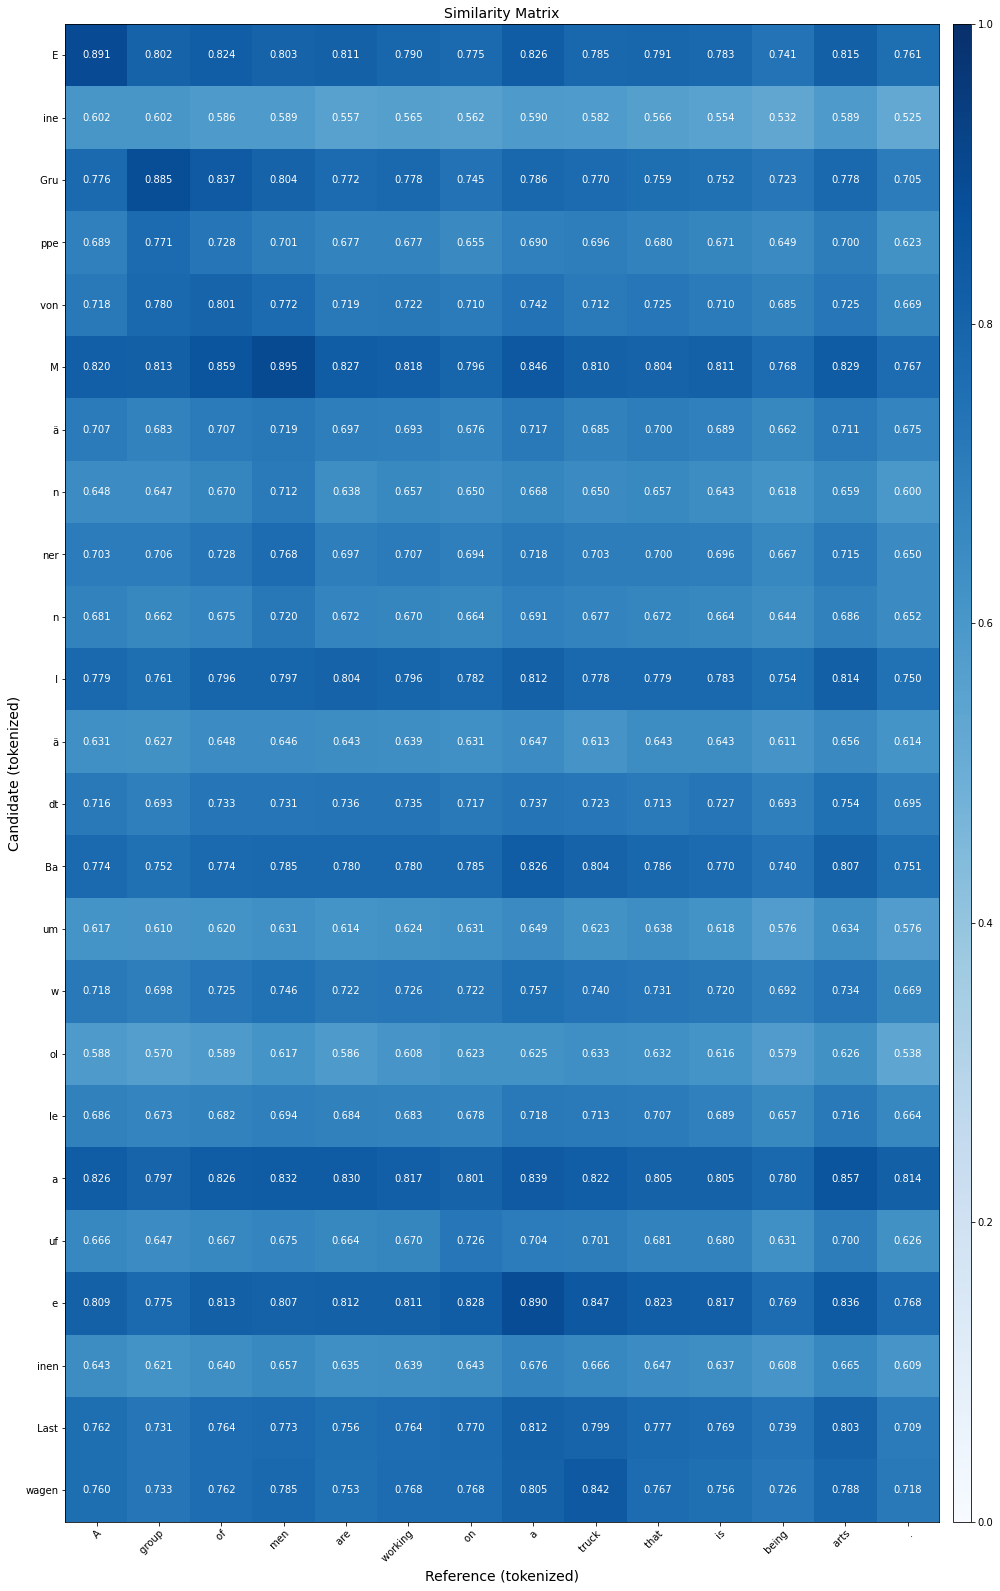

In [39]:
from bert_score import plot_example

cand = src[0]
ref = pred[0]
plot_example(cand, ref, lang="en")

German to English Translation with Bert Score Visualization:
1)  German: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
    English(Target): A group of men are loading cotton onto a truck
    English(Predicted): A group of men are working on a truck that is being arts .

Bert Score Visualization:


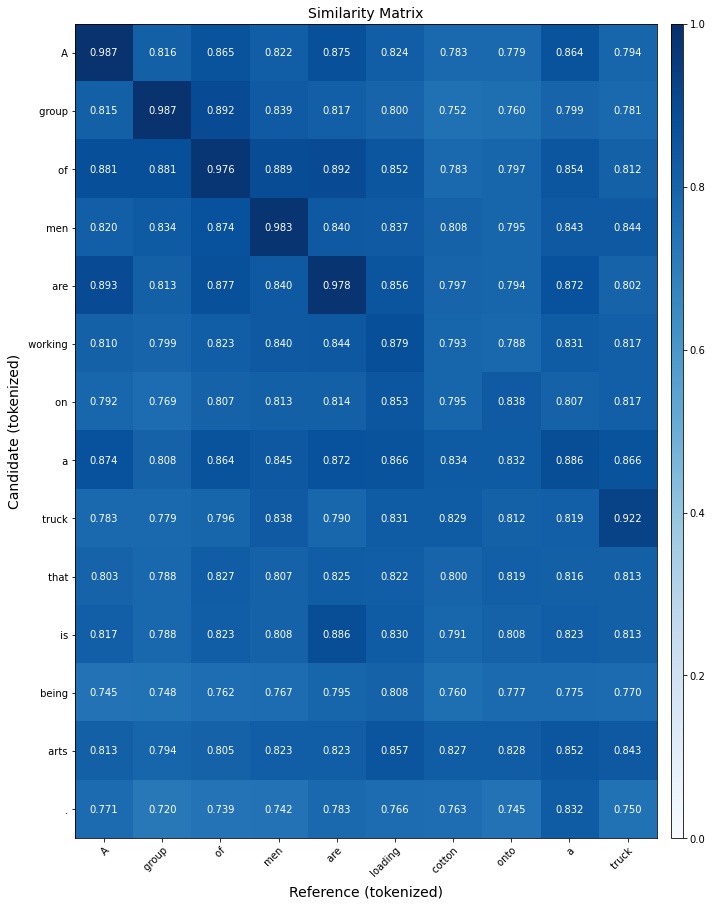



2)  German: Ein Mann schläft in einem grünen Raum auf einem Sofa.
    English(Target): A man sleeping in a green room on a couch.
    English(Predicted): A man is sleeping on a green room on a couch .

Bert Score Visualization:


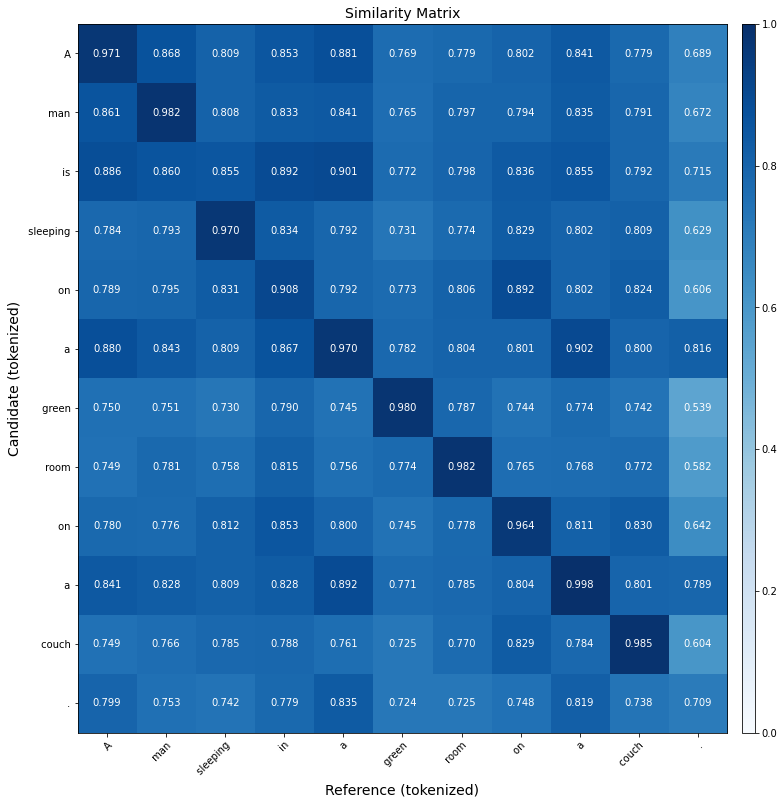



3)  German: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
    English(Target): A boy wearing headphones sits on a woman's shoulders.
    English(Predicted): A boy with glasses sits on the floor on a woman with a blue hair .

Bert Score Visualization:


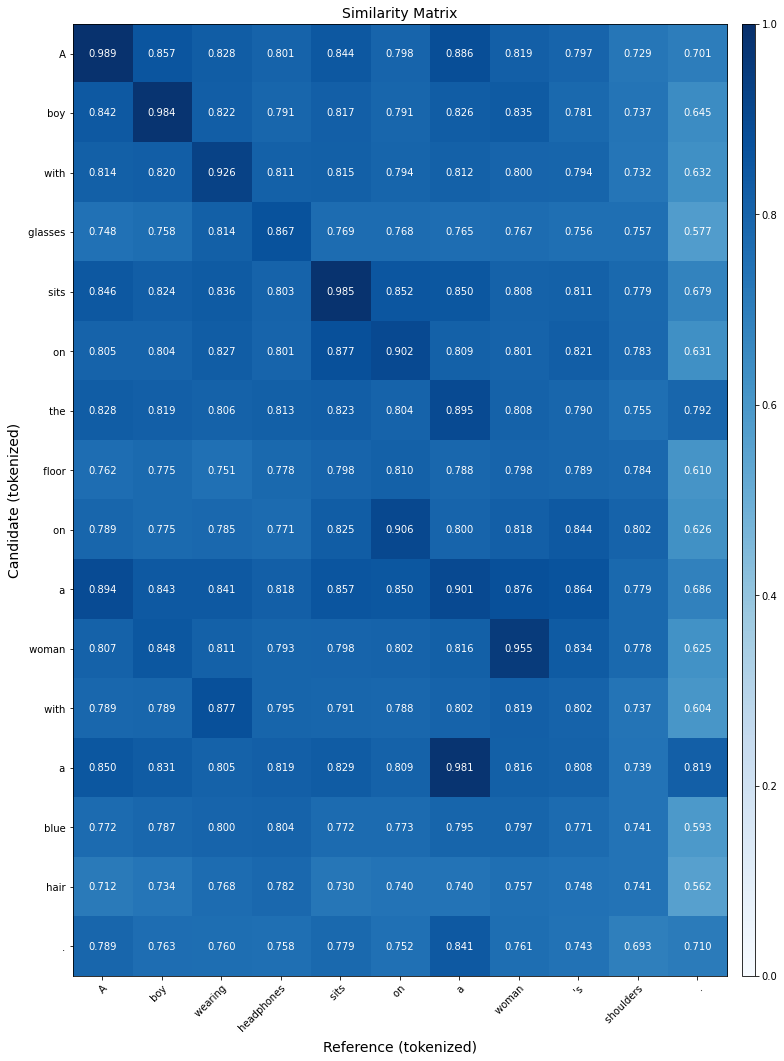



4)  German: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
    English(Target): Two men setting up a blue ice fishing hut on an iced over lake
    English(Predicted): Two men are building a blue mountain on a lake in a lake .

Bert Score Visualization:


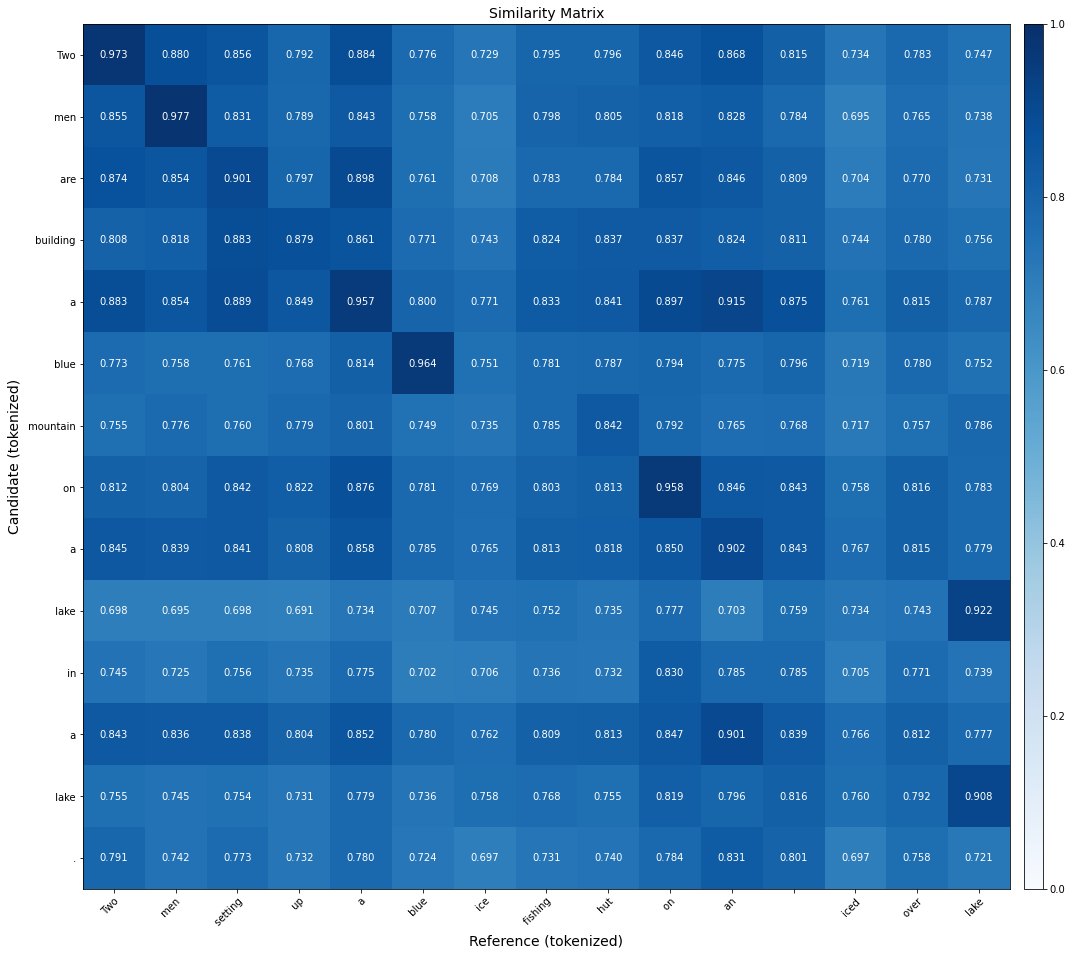

In [18]:
from bert_score import plot_example

num = 4
print('German to English Translation with Bert Score Visualization:')
for i in range(num):
  print(f'{i+1})  German: {src[i]}')
  print(f'    English(Target): {trg[i]}')
  print(f'    English(Predicted): {pred[i]}')
  print('\nBert Score Visualization:')

  plot_example(pred[i], trg[i], lang="en")
  print('\n')